# Mod 4 Project



# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('zillow_data.csv')

In [3]:
df.shape

(14723, 272)

In [4]:
df.head(2)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800


# Step 2: Data Preprocessing

In [5]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [6]:
get_datetimes(df)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

# Step 3: Reshape from Wide to Long Format

In [7]:
def melt_data(df):
    id_var = list(df.columns[:7])
    melted = pd.melt(df, id_vars= id_var, var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted
    

In [8]:
df = melt_data(df)

In [9]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [10]:
time_series = df.groupby('time').aggregate({'value':'mean'})
time_series.head()

,value
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312


# Step 4: EDA and Visualization

(1) find stantionarity in time series 
(2) use ARIMA to combine time series data with regression parameters 

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [12]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 8}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [13]:
import seaborn as sns 

/Users/minnafingerhood/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/minnafingerhood/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


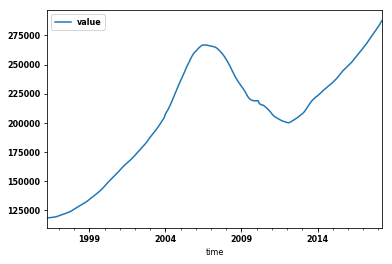

In [14]:
time_series.plot()
plt.show()

In [15]:
plot_acf(time_series, alpha =.05) #geometric autocorrelation... MA = 0 
plt.show()

NameError: name 'plot_acf' is not defined

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
fig = plt.figure(figsize = (18,8))
ax1 = fig.add_subplot(211)
plot_acf(time_series, lags = 60, alpha =.05, ax = ax1)
ax2 = fig.add_subplot(212)
plot_pacf(time_series,alpha = .05, ax = ax2)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
dftest = adfuller(time_series['value']) #d = 2 
dftest

p value > 0.05 therefore we fail to reject null hypothesis and data is seasonal 

# Step 5: SARIMA Modeling
Use SARIMA because we found seasonality, used p, d, q from our EDA above

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split

In [17]:
mod1 = sm.tsa.statespace.SARIMAX(time_series, order=(2,2,2), seasonal_order=(2,2,2,4),enforce_stationarity=False, enforce_invertibility=False)
results1 = mod1.fit()
results1.summary() #AIC = 3714.102 

/Users/minnafingerhood/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/minnafingerhood/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             value   No. Observations:                  265
Model:             SARIMAX(2, 2, 2)x(2, 2, 2, 4)   Log Likelihood               -1848.051
Date:                           Mon, 29 Jul 2019   AIC                           3714.102
Time:                                   09:48:41   BIC                           3745.576
Sample:                               04-01-1996   HQIC                          3726.778
                                    - 04-01-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4658      0.159      9.244      0.000       1.155       1.777
ar.L2         -0.5441      0.136     -4.015      0.000      -0.810      -0.279
ma.L1         -1.8206      0.121    -14.992      0.000      -2.059      -1.583
ma.L2          0.8247      0.122      6.779      0.000       0.586       1.063
ar.S.L4       -0.8665      0.106     -8.167      0.000      -1.074      -0.659
ar.S.L8       -0.3935      0.123     -3.199      0.001      -0.634      -0.152
ma.S.L4       -0.0076      0.105     -0.072      0.942      -0.213       0.198
ma.S.L8       -0.0710      0.089     -0.795      0.427      -0.246       0.104
sigma2      4.002e+05    4.7e+04      8.513      0.000    3.08e+05    4.92e+05
===================================================================================
Ljung-Box (Q):                       52.46   Jarque-Bera (JB):              2087.14
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -1.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
mod2 = sm.tsa.statespace.SARIMAX(time_series, order=(1,2,0), seasonal_order=(1,2,3,12),enforce_stationarity=False, enforce_invertibility=False)
results2 = mod2.fit()

/Users/minnafingerhood/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [19]:
results2.summary() #AIC value of 3064.977.. better than model1 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 2, 0)x(1, 2, 3, 12)   Log Likelihood               -1526.489
Date:                            Mon, 29 Jul 2019   AIC                           3064.977
Time:                                    09:48:47   BIC                           3084.827
Sample:                                04-01-1996   HQIC                          3073.009
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2733      0.043     -6.327      0.000      -0.358      -0.189
ar.S.L12      -0.6159      0.040    -15.367      0.000      -0.694      -0.537
ma.S.L12      -0.4072      0.038    -10.626      0.000      -0.482      -0.332
ma.S.L24      -0.2557      0.042     -6.084      0.000      -0.338      -0.173
ma.S.L36       0.2093      0.041      5.079      0.000       0.129       0.290
sigma2      2.012e+05   9194.454     21.878      0.000    1.83e+05    2.19e+05
===================================================================================
Ljung-Box (Q):                       50.52   Jarque-Bera (JB):              1193.47
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/minnafingerhood/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


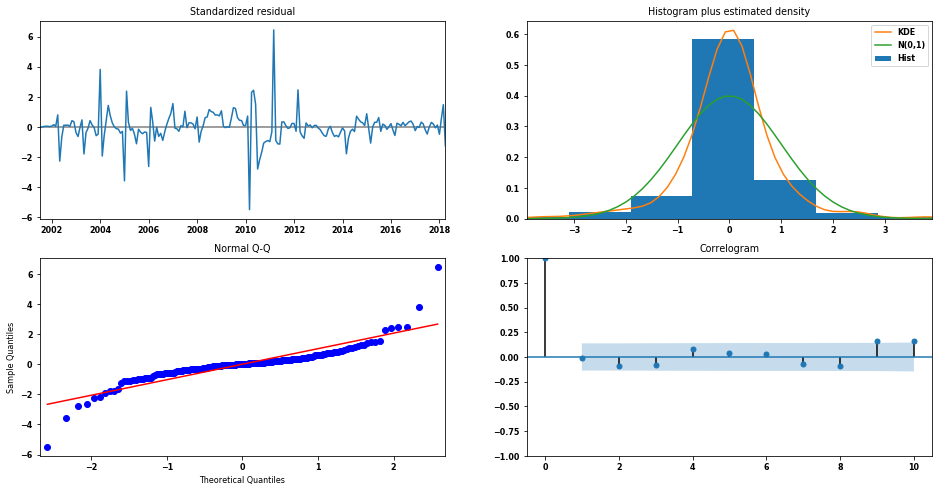

In [20]:
results2.plot_diagnostics(figsize = (16,8))
plt.show()

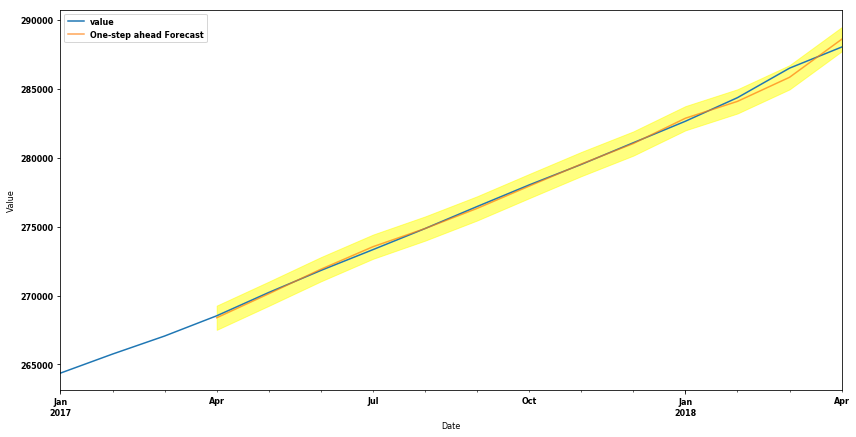

In [21]:
pred = results2.get_prediction(start=pd.to_datetime('2017-04-01'), dynamic=False)
pred_ci = pred.conf_int()
#observed values
ax = time_series['2017':].plot(label='observed')
#pred values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
#range of CI
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='yellow', alpha=.5)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()
plt.show()

In [23]:
stacked = df.set_index(['time', 'RegionID'])
stacked.drop(['RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis = 1, inplace = True)
stacked.dropna(subset=['value'], inplace = True)
delta_value = stacked.unstack()
cols = [str(x[1]) for x in delta_value.columns]
delta_value.columns = cols

In [24]:
delta_value.head()

,58196,58197,58200,58201,58202,58204,58205,58207,58209,58212,...,417461,418162,422745,422746,422747,677175,698721,738092,753843,753844
time,,,,,,,,,,,,,,,,,,,,,
1996-04-01,113100.0,161000.0,103100.0,133400.0,117500.0,115800.0,87000.0,88500.0,97200.0,91200.0,...,43800.0,153100.0,133400.0,251500.0,116300.0,169300.0,126100.0,133200.0,185900.0,71100.0
1996-05-01,112800.0,160100.0,103400.0,132700.0,117300.0,115700.0,87000.0,88500.0,97100.0,91100.0,...,44300.0,152500.0,133400.0,252400.0,117100.0,170500.0,127500.0,133900.0,185800.0,71000.0
1996-06-01,112600.0,159300.0,103600.0,132000.0,117100.0,115500.0,87100.0,88400.0,97000.0,91000.0,...,44900.0,151900.0,133600.0,253300.0,117800.0,171700.0,128900.0,134500.0,185600.0,70900.0
1996-07-01,112300.0,158600.0,103800.0,131400.0,117000.0,115300.0,87200.0,88300.0,96800.0,90800.0,...,45400.0,151300.0,133700.0,254400.0,118500.0,172900.0,130200.0,135300.0,185400.0,70800.0
1996-08-01,112100.0,158000.0,103900.0,130800.0,116800.0,115100.0,87400.0,88200.0,96600.0,90700.0,...,45800.0,150700.0,133900.0,255600.0,119200.0,174100.0,131300.0,136200.0,185400.0,70800.0


In [33]:
delta_value.pct_change(periods =1).sum().sort_values(ascending = False).head(5) #[62022, 62033, 62027, 60639, 62026]

62022    2.534154
62033    2.481206
62027    2.423896
60639    2.371251
62026    2.324117
dtype: float64

In [111]:
zip_series = pd.DataFrame(delta_value[['62022', '62033', '62027', '60639', '62026']])

In [64]:
#new_dataframe = pd.DataFrame(columns=['RegionID', '5yrs', '10yrs', '15yrs'])
new_dict = {}
for column in zip_series.columns:
    
    mod = sm.tsa.statespace.SARIMAX(delta_value[column], order=(1,2,0), seasonal_order=(1,2,3,12),enforce_stationarity=False, enforce_invertibility=False)
    results = mod.fit()
    
    pred_5yrs = results.get_prediction(start=pd.to_datetime('2022-04-01'), dynamic=True)
    pred_10yrs = results.get_prediction(start=pd.to_datetime('2027-04-01'), dynamic=True)
    pred_15yrs = results.get_prediction(start=pd.to_datetime('2033-04-01'), dynamic=True)
    #pred_ci = pred_5yrs.conf_int()
    new_dict[f'{column}'] = [pred_5yrs.predicted_mean, pred_10yrs.predicted_mean, pred_15yrs.predicted_mean]

/Users/minnafingerhood/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/minnafingerhood/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)
/Users/minnafingerhood/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)
/Users/minnafingerhood/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)
/Users/minnafingerhood

In [82]:
cleaned = {}
for k,v in new_dict.items():
    temp = []
    cleaned[f'{k}'] = temp
    for i in range(0,len(v)):
        temp.append(new_dict[f'{k}'][i][0])

In [109]:
test = pd.DataFrame.from_dict(cleaned).T
final = test.rename(columns={0: '5yrs', 1: '10yrs', 2: '15yrs'})
final

,5yrs,10yrs,15yrs
62022,3.367976e+06,8.077699e+06,1.926232e+07
62033,2.125009e+06,2.108438e+07,3.211644e+08
62027,9.255576e+05,-4.007296e+06,-1.965772e+07
60639,2.813358e+05,-6.712799e+06,-2.846107e+07
62026,3.573281e+06,7.711000e+06,1.869529e+07
